# Redes neurais do tipo LSTM para detecção de pontos de mudança em séries temporais de alta frequêcia

## Forecasting de preços de ações na bolsa de valores

Para esse estudo, utilizaremos os dados históricos do índice IBOVESPA (^BVSP), disponíveis no Yahoo Finance. Serão considerados os dados diários de `abril de 1993` a `março de 2024`.

Ref. https://finance.yahoo.com/quote/%5EBVSP/history/

### Preparação dos dados

Primeiramente, vamos carregar os dados históricos do índice IBOVESPA em um `Dataframe` e realizar uma análise exploratória dos dados.

In [2]:
import pandas as pd

df = pd.read_csv('^BVSP-apr-1993-mar-2024.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-04-27,24.799999,25.400000,24.500000,24.500000,24.500000,0.0
1,1993-04-28,24.500000,24.600000,23.700001,24.299999,24.299999,0.0
2,1993-04-29,24.299999,24.799999,23.700001,23.700001,23.700001,0.0
3,1993-04-30,23.700001,24.200001,23.700001,24.100000,24.100000,0.0
4,1993-05-03,24.100000,24.400000,23.799999,24.100000,24.100000,0.0
...,...,...,...,...,...,...,...
7813,2024-03-04,129176.000000,129307.000000,128278.000000,128341.000000,128341.000000,7967700.0
7814,2024-03-05,128336.000000,128989.000000,127823.000000,128098.000000,128098.000000,9692200.0
7815,2024-03-06,128099.000000,129323.000000,128099.000000,128890.000000,128890.000000,11057900.0
7816,2024-03-07,128890.000000,129188.000000,128033.000000,128340.000000,128340.000000,7350000.0


O primeiro passo é verificar se existem valores nulos no conjunto de dados.

In [3]:
df.isna().sum()

Date           0
Open         178
High         178
Low          178
Close        178
Adj Close    178
Volume       178
dtype: int64

Havendo esses valores, podemos removê-los sem prejuízo para a análise.

In [4]:
df = df.dropna()
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Ao analisar o conjunto de dados, podemos observar que há muitas datas faltantes, o que resulta em "buracos" na série temporal.

Esses "buracos" se devem ao fato de que a bolsa de valores não opera nos finais de semana e feriados.

Para preencher a série temporal de forma apropriada, utilizaremos o método de `forward fill`, que preenche os valores faltantes com o último valor conhecido.

Para isso, precisaremos definir o índice da série temporal, que no caso corresponderá à coluna `Date`.

In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.set_index('Date')

df.asfreq('D', method='ffill')

<ipython-input-5-ed299e26e690>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-04-27,24.799999,25.400000,24.500000,24.500000,24.500000,0.0
1993-04-28,24.500000,24.600000,23.700001,24.299999,24.299999,0.0
1993-04-29,24.299999,24.799999,23.700001,23.700001,23.700001,0.0
1993-04-30,23.700001,24.200001,23.700001,24.100000,24.100000,0.0
1993-05-01,23.700001,24.200001,23.700001,24.100000,24.100000,0.0
...,...,...,...,...,...,...
2024-03-04,129176.000000,129307.000000,128278.000000,128341.000000,128341.000000,7967700.0
2024-03-05,128336.000000,128989.000000,127823.000000,128098.000000,128098.000000,9692200.0
2024-03-06,128099.000000,129323.000000,128099.000000,128890.000000,128890.000000,11057900.0


Após sanitizar a série temporal, precisamos entender a distribuição dos dados e definir qual será a variável alvo (target).



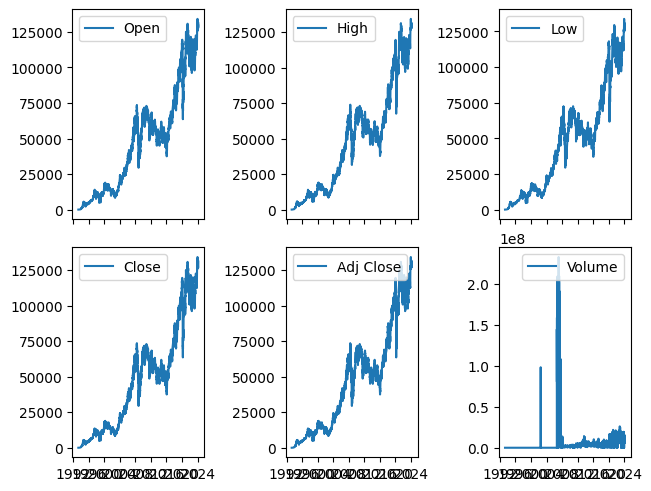

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, sharex=True, sharey=False, layout="constrained")

for col, ax in zip(df.columns, axs.flat):
    ax.plot(df.index, df[col], label=col)
    ax.legend()

plt.show()

In [7]:
df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999875,0.999814,0.999690,0.999690,0.148500
High,0.999875,1.000000,0.999824,0.999865,0.999865,0.148776
Low,0.999814,0.999824,1.000000,0.999890,0.999890,0.148291
Close,0.999690,0.999865,0.999890,1.000000,1.000000,0.148803
Adj Close,0.999690,0.999865,0.999890,1.000000,1.000000,0.148803
Volume,0.148500,0.148776,0.148291,0.148803,0.148803,1.000000


A partir da leitura dos gráficos e da matriz de correlação acima, podemos observar que a variável `Volume` possui baixa correlação com as demais variáveis (que indicam preço), o que sugere que ela não é uma boa candidata para ser a variável alvo. Portanto, vamos removê-la do conjunto de dados.

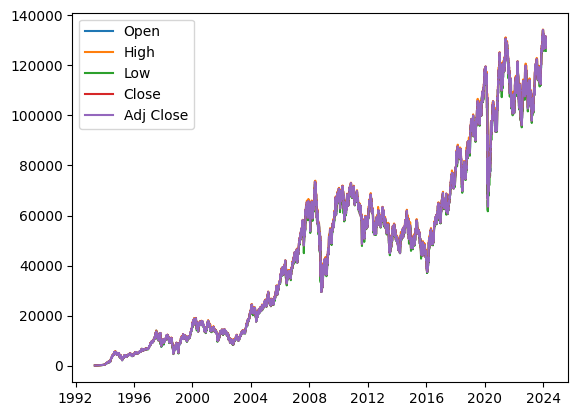

In [8]:
df = df.drop(columns=['Volume'])

for col in df.columns:
    plt.plot(df.index, df[col], label=col)
    plt.legend()

plt.show()

Nota-se que as variáveis restantes possuem alta correlação entre si, o que sugere que elas são resultados de um mesmo fenômeno.

Nesse caso, é difícil prever qual variável é a mais apropriada para ser a variável alvo. Entretanto, podemos considerar a definição dessas variáveis segundo a bibliografia especializada.

De acordo com a literatura, o preço de fechamento ajustado (`Adj Close`) deve ser a variável mais apropriada para a análise, uma vez que ela carrega mais contexto que as demais.

> While the closing price simply refers to the cost of shares at the end of the day, the adjusted closing price takes dividends, stock splits, and new stock offerings into account. The adjusted closing price is a more accurate indicator of stock value since it starts where the closing price finishes.
>
> Ref. https://groww.in/p/adjusted-closing-price#:~:text=While%20the%20closing%20price%20simply,where%20the%20closing%20price%20finishes.

In [9]:
data = df[['Adj Close']]
data

,Adj Close
Date,
1993-04-27,24.500000
1993-04-28,24.299999
1993-04-29,23.700001
1993-04-30,24.100000
1993-05-03,24.100000
...,...
2024-03-04,128341.000000
2024-03-05,128098.000000
2024-03-06,128890.000000


### Dados de treino e teste

Para a construção do modelo de previsão, precisamos dividir o conjunto de dados em partições de treino e teste.

A escolha do "ponto de corte" é um fator crítico para a qualidade do modelo, pois, tendo em vista o objetivo de criar um modelo capaz de "prever o futuro", é importante que os dados de treino e  teste tenham `baixa correlação` entre si, mas que sejam `representativos do conjunto de dados`.

Para evitar o problema de `overfitting`, vamos particionar os dados de modo que a `correlação` entre os conjuntos de treino e teste seja mínima.

Vamos implementar uma função que nos ajude a encontrar o `ponto de corte` ideal para a divisão dos dados, chamada `get_split_point`. Considerando a seguinte fórmula:

$$
C(t) = E[X(s) * X(t+s)] - E[X(s)] * E[X(t+s)]
$$

Onde:
- $C(t)$ é a autocorrelação de $X$ para lag $t$
- $t$ é o lag (atraso entre variáveis aleatórias X(s) e X(t+s))
- $s$ é o instante de tempo
- $E$ é o operador de esperança matemática (valor esperado)
- $X$ é a série temporal

A autocorrelação é uma medida de `correlação` entre os valores da série temporal em diferentes instantes de tempo, ou seja, é uma medida de `correlação` entre a série temporal e ela mesma deslocada no tempo.

Para simplificar a análise, vamos assumir a hipótese de que a série temporal é `estacionária`, ou seja, que a média e a variância dos dados não variam com o tempo.

Assim temos que  $E[X(s)] = \mu$ e $E[X(t+s)] = \mu$, logo:

$$
C(t) = E[X(s) * X(t+s)] - E[X(s)]^2
$$


A função `get_split_point` retorna o valor de `lag` que minimiza o valor absoluto da autocorrelação, ou seja, o valor de `lag` que maximiza a `independência` entre as séries temporais de treino e teste.

Ao encontrar o primeiro resultado menor ou igual a zero, retornamos o valor do `lag`, pois correlações extremamente negativas podem indicar que os conjuntos de dados estão `inversamente` correlacionados, o que também não é desejável.


In [10]:
def get_split_point(values):
    """
    C(t) = E[X(s)X(t+s)] - E[X(s)]E[X(t+s)]
    """
    corr_t = 1
    t = 1
    while corr_t > 0 and t < len(data):
        # t=1 <-> E[X(s)X(t+s)] = X(0)X(1) + X(1)X(2) + X(2)X(3) + ... + X(n-1)X(n)
        s = 0
        while s + t < len(data):
            corr_t += values[s] * values[s + t]
            s += 1
        corr_t = corr_t / len(data)

        # for stationary time series E[X(s)]E[X(t+s)] = E[X(s)]^2
        corr_t -= values.mean() ** 2
        t += 1

    return t


O tamanho do conjunto de dados de treino (`train_size`) será igual ao resultado da função `get_split_point`, enquanto o conjunto de dados de teste (`test_size`) será igual ao tamanho do conjunto de dados original menos o `dobro` do tamanho do conjunto de dados de treino.

> Aqui, estamos adicionando um "gap" de tamanho `train_size` entre os conjuntos de dados de treino e teste, para garantir que eles sejam `independentes` entre si.

In [11]:
train_size = get_split_point(data['Adj Close'].values)

train_data, test_data = data.iloc[0:train_size], data.iloc[train_size * 2:len(data)]

display(train_data)
display(test_data)

,Adj Close
Date,
1993-04-27,24.500000
1993-04-28,24.299999
1993-04-29,23.700001
1993-04-30,24.100000
1993-05-03,24.100000
...,...
1998-02-20,10319.000000
1998-02-23,10319.000000
1998-02-25,10546.000000


,Adj Close
Date,
2003-01-09,11912.0
2003-01-10,12243.0
2003-01-13,12110.0
2003-01-14,12175.0
2003-01-15,11971.0
...,...
2024-03-04,128341.0
2024-03-05,128098.0
2024-03-06,128890.0


### Normalização dos dados

Para melhorar a acurácia do modelo, vamos normalizar os dados de treino e teste.

A normalização coloca os dados no intervalo entre 0 e 1, sem distorcer as diferenças nas faixas de valores. Ou seja, ela não retira os outliers (valores extremos).

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

display(train_data_scaled)
display(test_data_scaled)

array([[5.88524494e-05],
       [4.41392451e-05],
       [0.00000000e+00],
       ...,
       [7.74079878e-01],
       [7.74889100e-01],
       [7.75919019e-01]])

array([[0.87457056],
       [0.89892079],
       [0.88913656],
       ...,
       [9.4801336 ],
       [9.43967249],
       [9.34631767]])

### Preparação dos dados para a modelagem

Para a modelagem, precisamos preparar os dados de treino e teste de forma que eles possam ser utilizados para treinar e testar o modelo. O treinamento é feito da seguinte maneira:

1. Dividimos os dados de treino em `X_train` e `y_train`, onde `X_train` é uma matriz contendo sequências de `seq_length` valores da série temporal e `y_train` é um vetor contendo o valor subsequente da série temporal. e.g. `X_train[0]` contém os valores de `X[0]` a `X[seq_length-1]` e `y_train[0]` contém o valor de `X[seq_length]`;
2. O mesmo é feito para os dados de teste, gerando `X_test` e `y_test`.

Os dados de teste são utilizados para avaliar a acurácia do modelo.

In [13]:
import numpy as np

seq_length = 10

def to_sequences(data, seq_length):
    """
    Appends a sequence of length `seq_length` to the x array and
    the next value of the sequence to the y array.
    """
    x, y = [], []
    for index in range(len(data) - seq_length):
        x.append(data[index: index + seq_length])
        y.append(data[index + seq_length])
    return np.array(x), np.array(y)

X_train, y_train = to_sequences(train_data_scaled, seq_length)
X_test, y_test = to_sequences(test_data_scaled, seq_length)

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]
assert X_train[0].shape[0] == seq_length

Antes de prosseguir, vamos congelar o `seed` para garantir a `reprodutibilidade` dos resultados.

Dessa forma, se o código for executado novamente, os resultados serão os mesmos.

In [14]:
import tensorflow as tf

tf.random.set_seed(7)

### Modelagem

Como sugere o título do notebook, vamos utilizar uma rede neural do tipo LSTM como modelo.

Para a criação da rede neural, vamos utilizar a classe `Sequential` da biblioteca Keras. Com o `keras.Sequential`, é possível criar facilmente uma rede neural empilhando camadas, passando uma lista para o construtor. Isso torna a criação de redes neurais simples e intuitiva, especialmente para redes com uma única entrada, uma única saída e uma sequência linear de camadas intermediárias.

A rede neural será composta por 3 camadas:
1. A primeira camada LSTM tem `units` unidades (ou neurônios) e espera uma entrada tridimensional com a forma `(seq_length, 1)`. Isso significa que ela espera sequências de comprimento `seq_length` com uma única característica em cada passo de tempo. Essa característica no nosso caso é o preço de fechamento ajustado da ação em um dado dia.
2. A segunda camada LSTM também tem `units` unidades e não precisa mais especificar a forma de entrada, pois ela pode inferir automaticamente a forma da entrada da camada anterior.
3. A última camada é uma camada `Dense` com um único neurônio, que é usada para produzir a saída da rede. Como é uma tarefa de regressão (prever um único valor), uma única saída é suficiente.


Em seguida, compilamos o modelo, especificando o otimizador e a função de perda (`loss`):

- `optimizer`: Este é o otimizador que será usado para ajustar os pesos da rede durante o treinamento, como o adam, sgd (gradiente descendente estocástico), entre outros. O otimizador é responsável por atualizar os pesos da rede com base nos gradientes calculados durante o treinamento, com o objetivo de minimizar a função de perda.

- `loss`: Esta é a função de perda que será minimizada durante o treinamento. A função de perda é uma medida de quão bem o modelo está performando em seus dados de treinamento, e é usada pelo otimizador para ajustar os pesos da rede. Para problemas de regressão, é comum usar a função de perda `mean_squared_error` para calcular o erro quadrático médio entre as previsões do modelo e os valores reais. Para outros tipos de problemas, como classificação, podem ser usadas outras funções de perda, como `categorical_crossentropy` para classificação categórica.

A função `build_model` retorna o modelo compilado, ela será utilizada para estimar quais `hiperparâmetros` são os mais adequados para o modelo.

> Os hiperparâmetros de um modelo são configurações que não são aprendidas durante o treinamento do modelo, mas que afetam diretamente o processo de treinamento e o desempenho final do modelo. Esses hiperparâmetros são definidos antes do início do treinamento

Para encontrar os hiperparâmetros mais adequados para o modelo, vamos utilizar a técnica de `grid search`, que consiste em testar todas as combinações possíveis de hiperparâmetros (definidas em um objeto `param_grid`) e escolher a que resulta no melhor desempenho do modelo.

O estimador utilizado para a busca em grade é o `KerasRegressor`, que é uma classe que encapsula o modelo de rede neural criado com o Keras, permitindo que ele seja utilizado como um estimador do scikit-learn.

> Em scikit-learn, um estimador é qualquer objeto que possa estimar parâmetros a partir de um conjunto de dados. Isso inclui algoritmos de aprendizado de máquina, como modelos de regressão linear, árvores de decisão, máquinas de vetores de suporte (SVMs), entre outros.




In [ ]:
import keras
from scikeras.wrappers import KerasRegressor

def build_model(optimizer='adam', loss='mean_squared_error', units=64):
    model = keras.Sequential([
        keras.layers.LSTM(units=units, input_shape=(seq_length, 1), return_sequences=True),
        keras.layers.LSTM(units),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)
    return model

lstm_estimator = KerasRegressor(build_fn=build_model, verbose=2, units=32)

Agora, definiremos o objeto `param_grid` que contém as combinações de hiperparâmetros que serão testadas.

Então, instaciaremos um objeto `GridSearchCV` que será utilizado para realizar a busca em grade.

Por fim, o método `fit` irá treinar e avaliar o modelo para todas as combinações de hiperparâmetros definidas em `param_grid`, retornando a combinação que resultou no melhor desempenho do modelo.

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'optimizer': ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta'],
    'units': [32, 64, 128, 256],
    'batch_size': [16, 32, 64, 128],
    'epochs': [50, 100, 150]
}

grid = GridSearchCV(estimator=lstm_estimator, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/150
75/75 - 4s - loss: 0.0093 - 4s/epoch - 50ms/step
Epoch 2/150
75/75 - 0s - loss: 6.5379e-04 - 321ms/epoch - 4ms/step
Epoch 3/150
75/75 - 0s - loss: 7.4989e-04 - 324ms/epoch - 4ms/step
Epoch 4/150
75/75 - 0s - loss: 6.6037e-04 - 322ms/epoch - 4ms/step
Epoch 5/150
75/75 - 0s - loss: 5.8307e-04 - 312ms/epoch - 4ms/step
Epoch 6/150
75/75 - 0s - loss: 7.6791e-04 - 317ms/epoch - 4ms/step
Epoch 7/150
75/75 - 0s - loss: 6.2644e-04 - 316ms/epoch - 4ms/step
Epoch 8/150
75/75 - 0s - loss: 5.7053e-04 - 314ms/epoch - 4ms/step
Epoch 9/150
75/75 - 0s - loss: 6.2463e-04 - 315ms/epoch - 4ms/step
Epoch 10/150
75/75 - 0s - loss: 6.3587e-04 - 310ms/epoch - 4ms/step
Epoch 11/150
75/75 - 0s - loss: 6.7969e-04 - 310ms/epoch - 4ms/step
Epoch 12/150
75/75 - 0s - loss: 5.0950e-04 - 312ms/epoch - 4ms/step
Epoch 13/150
75/75 - 0s - loss: 5.2935e-04 - 314ms/epoch - 4ms/step
Epoch 14/150
75/75 - 0s - loss: 4.9511e-04 - 314ms/epoch - 4ms/step
Epoch 15/150
75/75 - 0s - loss: 4.8747e-04 - 317ms/epoch - 4ms/

In [17]:
f'Best score: {grid_result.best_score_} with {grid_result.best_params_}'

"Best score: 0.9879500461141563 with {'batch_size': 16, 'epochs': 150, 'optimizer': 'rmsprop', 'units': 256}"

Enfim, criaremos um modelo com os hiperparâmetros encontrados e o treinaremos com os dados de treino.

In [23]:
model = tf.keras.Sequential([
    keras.layers.LSTM(units=256, input_shape=(seq_length, 1), return_sequences=True),
    keras.layers.LSTM(256),
    keras.layers.Dense(1)
])

model.compile(optimizer='rmsprop', loss='mean_squared_error')

In [24]:
model.fit(X_train, y_train, epochs=150, batch_size=16, verbose=2)

Epoch 1/150
75/75 - 3s - loss: 0.0099 - 3s/epoch - 40ms/step
Epoch 2/150
75/75 - 0s - loss: 0.0026 - 326ms/epoch - 4ms/step
Epoch 3/150
75/75 - 0s - loss: 0.0032 - 339ms/epoch - 5ms/step
Epoch 4/150
75/75 - 0s - loss: 0.0019 - 328ms/epoch - 4ms/step
Epoch 5/150
75/75 - 0s - loss: 0.0019 - 317ms/epoch - 4ms/step
Epoch 6/150
75/75 - 0s - loss: 0.0018 - 325ms/epoch - 4ms/step
Epoch 7/150
75/75 - 0s - loss: 0.0012 - 321ms/epoch - 4ms/step
Epoch 8/150
75/75 - 0s - loss: 0.0016 - 316ms/epoch - 4ms/step
Epoch 9/150
75/75 - 0s - loss: 0.0016 - 309ms/epoch - 4ms/step
Epoch 10/150
75/75 - 0s - loss: 0.0011 - 312ms/epoch - 4ms/step
Epoch 11/150
75/75 - 0s - loss: 0.0013 - 316ms/epoch - 4ms/step
Epoch 12/150
75/75 - 0s - loss: 0.0011 - 328ms/epoch - 4ms/step
Epoch 13/150
75/75 - 0s - loss: 0.0010 - 327ms/epoch - 4ms/step
Epoch 14/150
75/75 - 0s - loss: 9.5134e-04 - 341ms/epoch - 5ms/step
Epoch 15/150
75/75 - 0s - loss: 9.2340e-04 - 326ms/epoch - 4ms/step
Epoch 16/150
75/75 - 0s - loss: 0.0012 - 33

O modelo treinado será utilizado para fazer previsões com os dados de teste.

In [25]:
predicted_values = model.predict(X_test)

164/164 [==============================] - 1s 2ms/step


### Avaliação do modelo

Para avaliar o modelo, plotaremos um gráfico com as previsões do modelo e os valores reais e calcularemos a estatística `MAPE` (Mean Absolute Percentage Error).

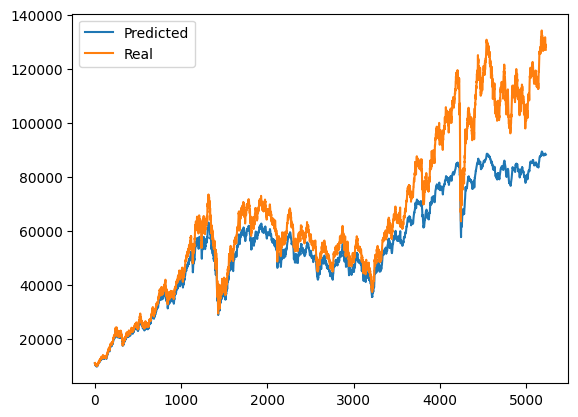

In [26]:
predicted = scaler.inverse_transform(predicted_values)
actual_y_test = scaler.inverse_transform(y_test)

plt.plot(predicted, label='Predicted')
plt.plot(actual_y_test, label='Real')
plt.legend()
plt.show()

A estatística `MAPE`, também conhecida como `MAPD` (mean absolute percentage deviation), é uma medida de acurácia de previsão de um modelo.

Ela é calculada como a média do valor absoluto das diferenças entre as previsões do modelo e os valores reais, dividido pelo valor real.

$$
MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$

A estatística `MAPE` é comunmente utilizada em problemas de regressão, e foi escolhida por ser uma medida de erro relativo de fácil interpretação.

Ref. https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

![MAPE interpretation](https://www.researchgate.net/publication/257812432/figure/tbl1/AS:601657310203931@1520457689632/nterpretation-of-typical-MAPE-values.png)


In [27]:
def calculate_mape(predicted, actual):
  return  np.mean(np.abs((actual - predicted) / actual)) * 100

mape = calculate_mape(predicted, actual_y_test)

f'Mean Absolute Percentage Error: {mape}'

'Mean Absolute Percentage Error: 12.654027501443355'

### Resultados

De acordo com a interpretação da estatística `MAPE`, obtivemos um `bom preditor`. Isso significa que o modelo é capaz de prever o preço de fechamento ajustado da ação com um erro percentual médio de `aproximadamente 12.7%`.

### Próximos passos

Esse resultado é promissor, mas ainda há espaço para melhorias, o que é de fato animador!😄

- Implementar um modelo de previsão em tempo real, que seja capaz de prever o preço de fechamento ajustado da ação com base nos dados mais recentes;
- Aumentar a frequência da série temporal. Atualmente, estamos utilizando dados diários, mas podemos utilizar dados intradiários (por exemplo, a cada 5 minutos) para prever o preço da ação em um horizonte de tempo mais curto;
- Explorar a predição de pontos de mudança na série temporal, que podem indicar oportunidades de compra ou venda de ações.